In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [3]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
seed_everything(5)

In [4]:
#Weight scaled Conv2d (Equalized Learning Rate)
#每次迭代都对weights进行归一化，起到均衡学习率的作用
class WSConv2d(nn.Module):
    def __init__(
        self,in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super().__init__()
        self.conv=nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        nl=self.conv.weight[0].numel()#每个输出通道的参数量
        self.scale=(gain/nl)**0.5#控制权重方差
        self.bias=self.conv.bias
        self.conv.bias=None
        
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)
        
    def forward(self,x):
        #bias.shape:(1,channels,1,1)
        #self.conv(x*self.scale).shape:(batch_size,channels,img_size,img_size)
        #相加时会进行广播
        return self.conv(x*self.scale)+self.bias.view(1,self.bias.shape[0],1,1)
    
x=torch.randn((32,3,32,32))
ws=WSConv2d(3,10)
ws(x).shape

torch.Size([32, 10, 32, 32])

In [5]:
## 像素归一化
## 沿每个通道进行归一化，使通道L2范数为1
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps=1e-8
    def forward(self,x):
        #print(torch.mean(x**2,dim=1,keepdim=True).shape)#(batch_size,1,img_size,img_size)
        #print(torch.mean(x**2,dim=1,keepdim=False).shape)#(batch_size,img_size,img_size)
        return x/(torch.sqrt(torch.mean(x**2,dim=1,keepdim=True))+self.eps)
pixelnorm=PixelNorm()
pixelnorm(x).shape


torch.Size([32, 3, 32, 32])

In [6]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,use_PixelNorm=True):
        super().__init__()
        self.use_pn=use_PixelNorm
        self.conv1=WSConv2d(in_channels,out_channels)
        self.conv2=WSConv2d(out_channels,out_channels)
        self.leaky=nn.LeakyReLU(0.2)
        self.pn=PixelNorm()
    def forward(self,x):
        x=self.leaky(self.conv1(x))
        x=self.pn(x) if self.use_pn else x
        x=self.leaky(self.conv2(x))
        x=self.pn(x) if self.use_pn else x
        return x

In [7]:
#当对特征图进行上采样时，可能需要减少输出特征图个数，这里通过factors进行控制：
factors=[1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

In [8]:
class Generator(nn.Module):
    def __init__(self,z_dim,in_channels,img_channels=3):
        super().__init__()
        self.initial=nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),#扩大4倍
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )
        self.initial_rgb=WSConv2d(in_channels,img_channels,1,1,0)
        
        self.prog_blocks,self.rgb_layers=(
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )
        for i in range(len(factors)-1):
            conv_c_in=int(in_channels*factors[i])
            conv_c_out=int(in_channels*factors[i+1])
            self.prog_blocks.append(ConvBlock(conv_c_in,conv_c_out))
            self.rgb_layers.append(WSConv2d(conv_c_out,img_channels,1,1,0))
        
    def fade_in(self,alpha,upscaled,generator):#alpha从0到1
        return torch.tanh(alpha*generator+(1-alpha)*upscaled)
    def forward(self,x,alpha,steps):
        out=self.initial(x)
        if steps==0:
            return self.initial_rgb(out)

        #前step-1层直接经过pro_blocks
        for step in range(steps):
            upscaled=F.interpolate(out,scale_factor=2.0,mode='nearest')
            out=self.prog_blocks[step](upscaled)
        #扩大两倍过程中通道数不变，故可以直接使用上一层的TO_RGB,而且进入新阶段后，旧的TO_RGB层会被废弃
        final_upscaled=self.rgb_layers[steps-1](upscaled)
        #经过prog_block后通道数可能改变所以要使用新一层的TO_RGB
        final_out=self.rgb_layers[steps](out)
        return self.fade_in(alpha,final_upscaled,final_out)
            

In [9]:
class Discriminator(nn.Module):
    def __init__(self,z_dim,in_channels,img_channels=3):
        super().__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)
        
        for i in range(len(factors)-1,0,-1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            #判别器不需要像素归一化
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_PixelNorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )#与生成器对称
            
        self.initial_rgb= WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool=nn.AvgPool2d(kernel_size=2,stride=2)
        
        self.final_block=nn.Sequential(
            #+1是因为增加了 minibatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            #4*4->1*1
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            #相当于全连接
            WSConv2d(in_channels, 1, kernel_size=1, padding=0, stride=1), 
        )
    def fade_in(self,alpha,downscaled,out):
        return out*alpha+(1-alpha)*downscaled
    
    def minbatch_std(self,x):
        batch_statistics=(
            #计算每个batch对应位置的数字求std,然后所有std求平均得到一个数，把这个数扩展为一个feature map送入判别器
            torch.std(x,dim=0).mean().repeat(x.shape[0],1,x.shape[2],x.shape[3])
        )
        return torch.cat([x,batch_statistics],dim=1)
    
    def forward(self,x,alpha,steps):
        cur_step = len(self.prog_blocks) - steps
        out=self.leaky(self.rgb_layers[cur_step](x))
        if steps==0:#4*4
            out=self.minbatch_std(out)
            #print(out)
            #print(self.final_block(out))
            return self.final_block(out).view(out.shape[0],-1)
        
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))
        
        out=self.fade_in(alpha,downscaled,out)
        
        for step in range(cur_step+1,len(self.prog_blocks)):
            out=self.prog_blocks[step](out)
            out=self.avg_pool(out)
        out=self.minbatch_std(out)
        return self.final_block(out).view(out.shape[0],-1)

   
        

In [10]:
from math import log2
Z_DIM = 100
IN_CHANNELS = 256
gen = Generator(Z_DIM, IN_CHANNELS, img_channels=3)
critic = Discriminator(Z_DIM, IN_CHANNELS, img_channels=3)

for img_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    num_steps = int(log2(img_size / 4))
    x = torch.randn((1, Z_DIM, 1, 1))
    z = gen(x, 0.5, steps=num_steps)
    assert z.shape == (1, 3, img_size, img_size)
    out = critic(z, alpha=0.5, steps=num_steps)
    print(out)
    assert out.shape == (1, 1)
    print(f"Success! At img size: {img_size}")

tensor([[nan]], grad_fn=<ViewBackward0>)
Success! At img size: 4
tensor([[nan]], grad_fn=<ViewBackward0>)
Success! At img size: 8
tensor([[nan]], grad_fn=<ViewBackward0>)
Success! At img size: 16
tensor([[nan]], grad_fn=<ViewBackward0>)
Success! At img size: 32
tensor([[nan]], grad_fn=<ViewBackward0>)
Success! At img size: 64
tensor([[nan]], grad_fn=<ViewBackward0>)
Success! At img size: 128
tensor([[nan]], grad_fn=<ViewBackward0>)
Success! At img size: 256
tensor([[nan]], grad_fn=<ViewBackward0>)
Success! At img size: 512
tensor([[nan]], grad_fn=<ViewBackward0>)
Success! At img size: 1024


In [11]:
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)


def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [32]:
START_TRAIN_AT_IMG_SIZE = 8
DATASET = 'celeb_dataset'
CHECKPOINT_GEN = "generator.pth"
CHECKPOINT_CRITIC = "critic.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_MODEL = True
LOAD_MODEL = True
LEARNING_RATE = 1e-3
BATCH_SIZES = [32, 32, 32, 16, 16, 16, 16, 8, 4]
CHANNELS_IMG = 1
Z_DIM = 256  # should be 512 in original paper
IN_CHANNELS = 256  # should be 512 in original paper
CRITIC_ITERATIONS = 1
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [10] * len(BATCH_SIZES)
FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(DEVICE)
NUM_WORKERS = 4

In [33]:
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from math import log2
from tqdm import tqdm

In [34]:
gen = Generator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(
    Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
).to(DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
)
scaler_critic = torch.cuda.amp.GradScaler()
scaler_gen = torch.cuda.amp.GradScaler()

if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC, critic, opt_critic, LEARNING_RATE,
        )

=> Loading checkpoint
=> Loading checkpoint


In [35]:
def show(imgs,figsize=(6,6)):
    plt.figure(figsize=figsize)
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
):
    loop = tqdm(loader, leave=True)
    g_list=[]
    d_list=[]
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)
        
        g_list.append(loss_gen.item())
        d_list.append(loss_critic.item())
        if batch_idx % 500 == 0 :
            
            with torch.no_grad():
                fixed_fakes = gen(FIXED_NOISE, alpha, step) 
            show(fixed_fakes)
            plt.plot(range(len(g_list)),g_list)
            plt.plot(range(len(g_list)),d_list)
            plt.show()
            plot_to_tensorboard(
                writer,
                loss_critic.item(),
                loss_gen.item(),
                real.detach(),
                fixed_fakes.detach(),
                tensorboard_step,
            )
            tensorboard_step += 1

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )

    return tensorboard_step, alpha

In [36]:
## 数据准备
import torchvision
from torchvision import transforms
def get_loader(img_size):
    dataset=torchvision.datasets.MNIST(
        './',
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size),
             transforms.ToTensor(),
             transforms.RandomHorizontalFlip(p=0.5),
                transforms.Normalize(
                    [0.5 for _ in range(CHANNELS_IMG)],
                    [0.5 for _ in range(CHANNELS_IMG)],
                ),
            ]

        ) 
    )
    batch_size = BATCH_SIZES[int(log2(img_size / 4))]
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,drop_last=True)
    return dataloader,dataset


Current image size: 32
Epoch [1/10]


  0%|          | 0/3750 [00:00<?, ?it/s]

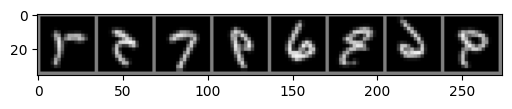

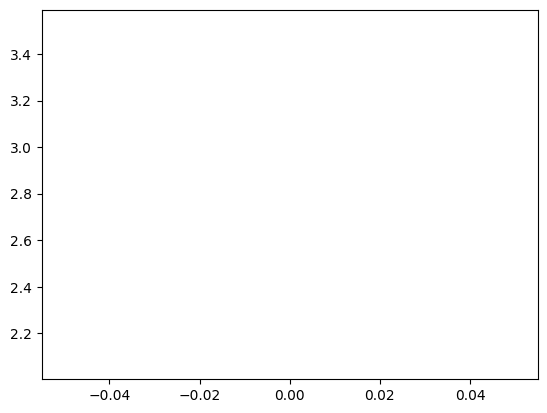

 13%|█▎        | 500/3750 [01:18<08:30,  6.37it/s, gp=0.00637, loss_critic=-1.28]  

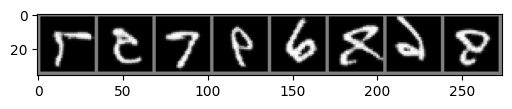

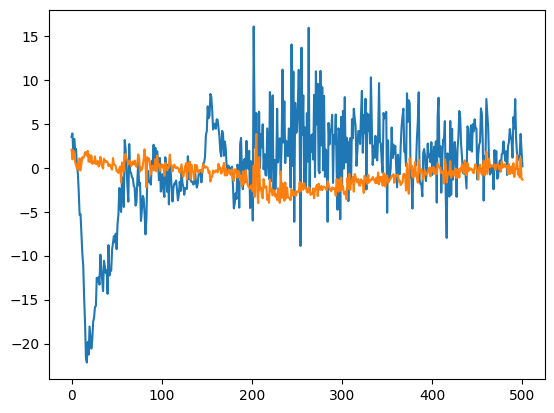

 27%|██▋       | 1000/3750 [02:37<07:09,  6.40it/s, gp=0.00251, loss_critic=-.786] 

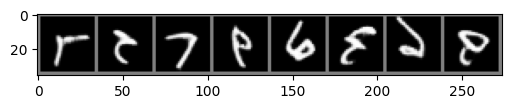

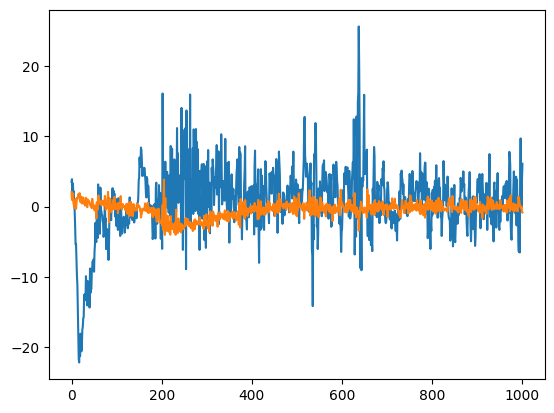

 40%|████      | 1500/3750 [03:55<05:55,  6.34it/s, gp=0.0104, loss_critic=-.115]   

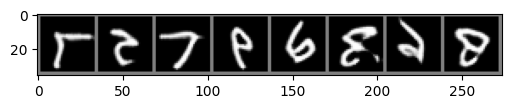

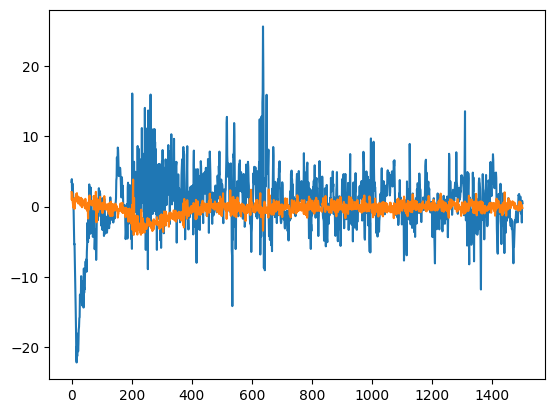

 53%|█████▎    | 2000/3750 [05:14<04:32,  6.41it/s, gp=0.00488, loss_critic=-.161]  

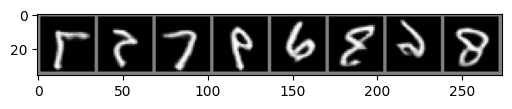

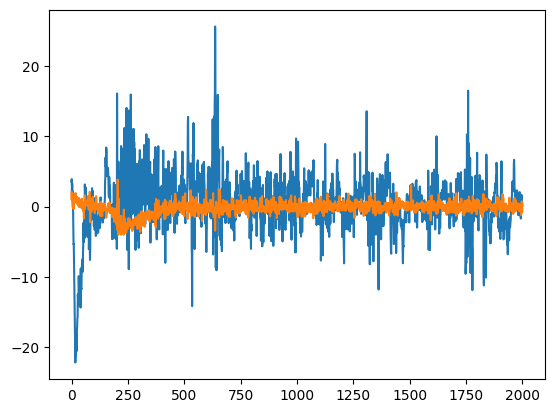

 67%|██████▋   | 2500/3750 [06:33<03:15,  6.39it/s, gp=0.0171, loss_critic=0.376]   

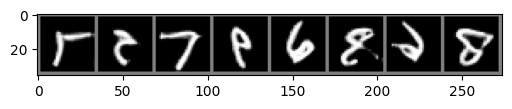

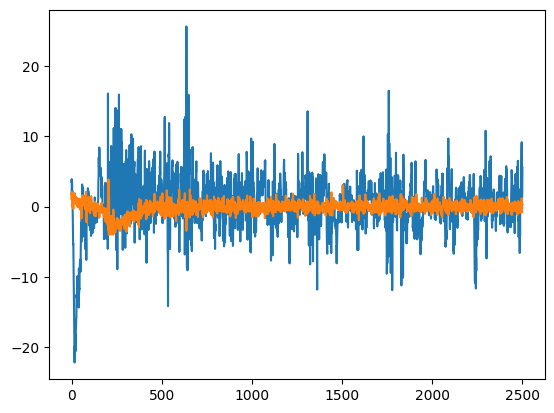

 80%|████████  | 3000/3750 [07:51<01:57,  6.36it/s, gp=0.00778, loss_critic=0.768]  

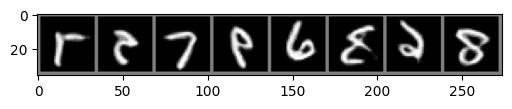

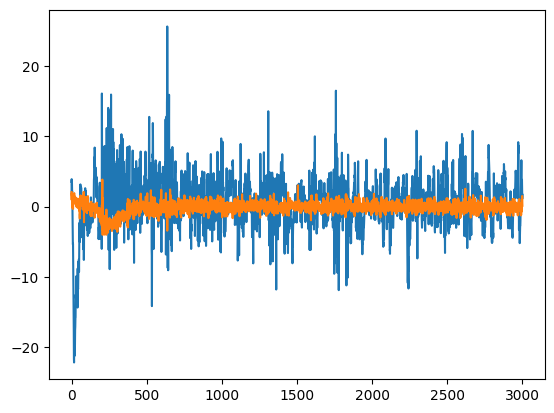

 93%|█████████▎| 3500/3750 [09:10<00:39,  6.39it/s, gp=0.00584, loss_critic=-.35]    

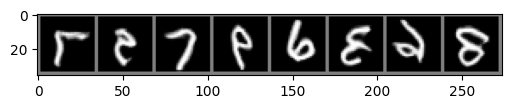

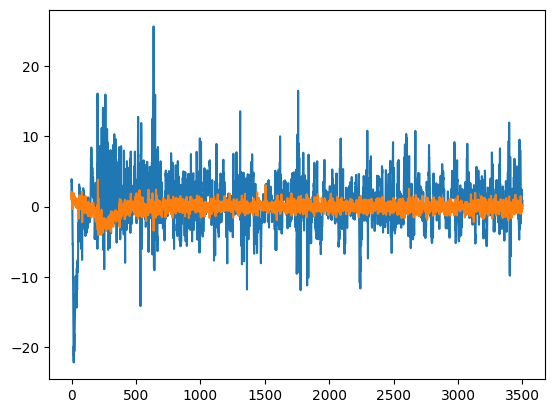

100%|██████████| 3750/3750 [09:50<00:00,  6.35it/s, gp=0.0337, loss_critic=-2.53]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/10]


  0%|          | 0/3750 [00:00<?, ?it/s]

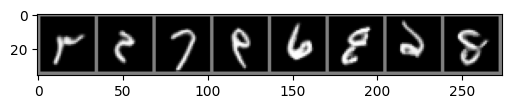

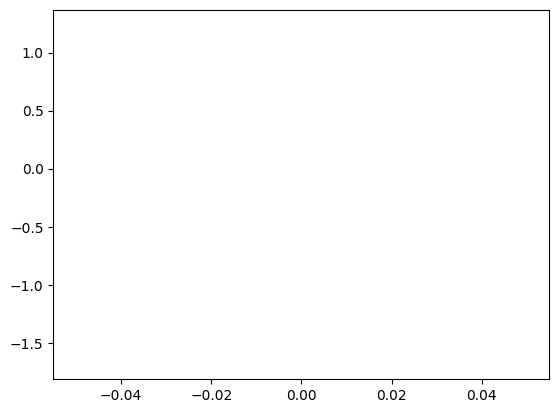

  1%|          | 37/3750 [00:06<10:27,  5.92it/s, gp=0.00754, loss_critic=0.797]


KeyboardInterrupt: 

In [37]:
from IPython.display import clear_output
gen.train()
critic.train()
step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
tensorboard_step = 0
writer = SummaryWriter(f"./")
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    clear_output()
    alpha = 1e-5  # start with very low alpha
    loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        tensorboard_step, alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
            tensorboard_step,
            writer,
            scaler_gen,
            scaler_critic,
        )

        if SAVE_MODEL:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(critic, opt_critic, filename=CHECKPOINT_CRITIC)

    step += 1  # progress to the next img size

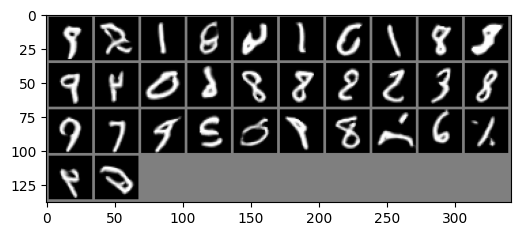

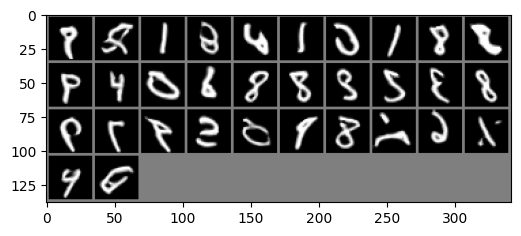

In [39]:
noise = torch.randn(32, Z_DIM, 1, 1).to(DEVICE)
fixed_fakes = gen(noise, alpha, step) 
show(fixed_fakes)
flip=transforms.RandomHorizontalFlip(p=1)
show(flip(fixed_fakes))